In [46]:
import torch
import torch.nn as nn
import torch.optim as optim
from matplotlib import pyplot as plt

The autoencoder part is kind of based on [this Medium post](https://medium.com/pytorch/implementing-an-autoencoder-in-pytorch-19baa22647d1) and the PyTorch code is based on Part 1 Chapter 7 of the PyTorch book.

In [47]:
class AE_sample(nn.Module):
    '''this is copied from in the Medium post for reference
    However, this class isn't used and a format closer to the PyTorch book is used in the following code.
    https://medium.com/pytorch/implementing-an-autoencoder-in-pytorch-19baa22647d1
    '''
    def __init__(self, **kwargs):
        super().__init__()
        self.encoder_hidden_layer = nn.Linear(in_features=kwargs["input_shape"], out_features=128)
        self.encoder_output_layer = nn.Linear(in_features=128, out_features=128)
        self.decoder_hidden_layer = nn.Linear(in_features=128, out_features=128)
        self.decoder_output_layer = nn.Linear(in_features=128, out_features=kwargs["input_shape"])
    
    def forward(self, features):
        activation = self.encoder_hidden_layer(features)
        activation = torch.relu(activation)
        code = self.encoder_output_layer(activation)
        code = torch.relu(code)
        activation = torch.relu(activation)
        activation = self.decoder_output_layer(activation)
        reconstructed = torch.relu(activation)
        return reconstructed

Create autoencoder network

In [48]:
input_shape = 784
ae_model = nn.Sequential(
    ## encoder
    nn.Linear(in_features=input_shape, out_features=300),
    nn.ReLU(),
    nn.Linear(in_features=300, out_features=100),
    nn.ReLU(),
    nn.Linear(in_features=100, out_features=10),
    nn.ReLU(),
    ## decoder
    nn.Linear(in_features=10, out_features=100),
    nn.ReLU(),
    nn.Linear(in_features=100, out_features=300),
    nn.ReLU(),
    nn.Linear(in_features=300, out_features=input_shape),
    nn.ReLU()
    )

Next, load MNIST dataset as tensors

In [49]:
from torchvision import datasets, transforms
data_path = "./data/"
transform = transforms.Compose([transforms.ToTensor()])
mnist = datasets.MNIST(data_path, train=True, transform=transform, download=True)
mnist_val = datasets.MNIST(data_path, train=False, transform=transform, download=True)

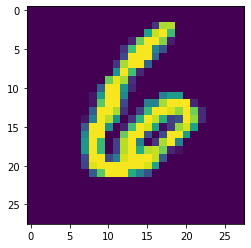

number:6	size:torch.Size([1, 28, 28])


In [50]:
img, number = mnist[13]

plt.imshow(img.permute(1,2,0))
plt.show()
print(f"number:{number}\tsize:{img.shape}")

Of course, before training, the autoencoder just emits gibberish. 

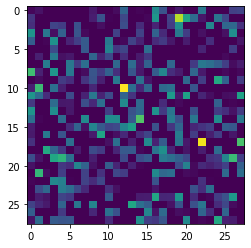

In [51]:
out = ae_model(img.view(-1).unsqueeze(0))
plt.imshow(out.view(1,28,28).permute(1,2,0).detach()) # detach disables the gradient or something
plt.show()

Finally, run the training. Hyperparameters are very arbitrarily decided by me, for now...

In [52]:
train_loader = torch.utils.data.DataLoader(mnist, batch_size=100, shuffle=True)
learning_rate = 1e-3

optimizer = optim.Adam(ae_model.parameters(), lr=learning_rate)
loss_fn = nn.MSELoss()

n_epochs = 30

for epoch in range(n_epochs):
    loss = 0
    for imgs, _ in train_loader:
        inputs = imgs.view(imgs.shape[0], -1)
        outputs = ae_model(inputs)
        train_loss = loss_fn(outputs, inputs)

        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
        loss += train_loss.item()
    loss = loss/len(train_loader)
    print(f"Epoch: {epoch}\tLoss: {loss}")

Epoch: 0	Loss: 0.04581741956373056
Epoch: 1	Loss: 0.03306636943171422
Epoch: 2	Loss: 0.031153646055608986
Epoch: 3	Loss: 0.03007075690974792
Epoch: 4	Loss: 0.029107880952457588
Epoch: 5	Loss: 0.02846204285820325
Epoch: 6	Loss: 0.028017748330409327
Epoch: 7	Loss: 0.027651694423208636
Epoch: 8	Loss: 0.027351227883870403
Epoch: 9	Loss: 0.027058783434331418
Epoch: 10	Loss: 0.026570160097132128
Epoch: 11	Loss: 0.026315306903173526
Epoch: 12	Loss: 0.026141098293786247
Epoch: 13	Loss: 0.025869315943370264
Epoch: 14	Loss: 0.025558062385146817
Epoch: 15	Loss: 0.025405813604593278
Epoch: 16	Loss: 0.025265049726391833
Epoch: 17	Loss: 0.025158544204508266
Epoch: 18	Loss: 0.024996744384989143
Epoch: 19	Loss: 0.024916485628734032
Epoch: 20	Loss: 0.024807244542365273
Epoch: 21	Loss: 0.024708446155612667
Epoch: 22	Loss: 0.024597518108785153
Epoch: 23	Loss: 0.024144889144226907
Epoch: 24	Loss: 0.024055484232182303
Epoch: 25	Loss: 0.023972178647915524
Epoch: 26	Loss: 0.023898906335234643
Epoch: 27	Loss:

Show the autoencoder applied to some of the data in the verification dataset. As you can see, the autoencoder can vaguely re-create the given data!

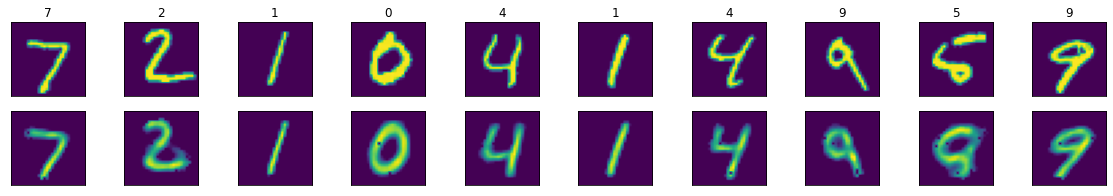

In [53]:
N = 10
fig = plt.figure(figsize=(N*2,3))
for i in range(N):
    in_t, number = mnist_val[i]
    out_t = ae_model(in_t.view(-1).unsqueeze(0))
    in_img = in_t.permute(1,2,0)
    out_img = out_t.view(1,28,28).permute(1,2,0).detach()
    ax = fig.add_subplot(2, N, 1 + i, xticks=[], yticks=[])
    ax.set_title(f"{number}")
    plt.imshow(in_img)
    ax = fig.add_subplot(2, N, 1 + N + i, xticks=[], yticks=[])
    plt.imshow(out_img)
plt.show()

Next I'll attempt to create an encoder network based on the learned weights. Not sure what the proper procedure is for copying part of graphs, but I'm basing it on https://discuss.pytorch.org/t/how-to-load-part-of-pre-trained-model/1113/2

cf: https://pytorch.org/tutorials/beginner/saving_loading_models.html

In [54]:
trained_dict = ae_model.state_dict()
print(trained_dict.keys())

encoder_model = nn.Sequential(
    ## encoder
    nn.Linear(in_features=input_shape, out_features=300),
    nn.ReLU(),
    nn.Linear(in_features=300, out_features=100),
    nn.ReLU(),
    nn.Linear(in_features=100, out_features=10),
    nn.ReLU(),
    )
encoder_model_dict = {k: v for k,v in trained_dict.items() if k in encoder_model.state_dict()}
encoder_model.load_state_dict(encoder_model_dict)

odict_keys(['0.weight', '0.bias', '2.weight', '2.bias', '4.weight', '4.bias', '6.weight', '6.bias', '8.weight', '8.bias', '10.weight', '10.bias'])


<All keys matched successfully>

You can see that the latent space has a somewhat similar feature for the same digit. Self-supervision!

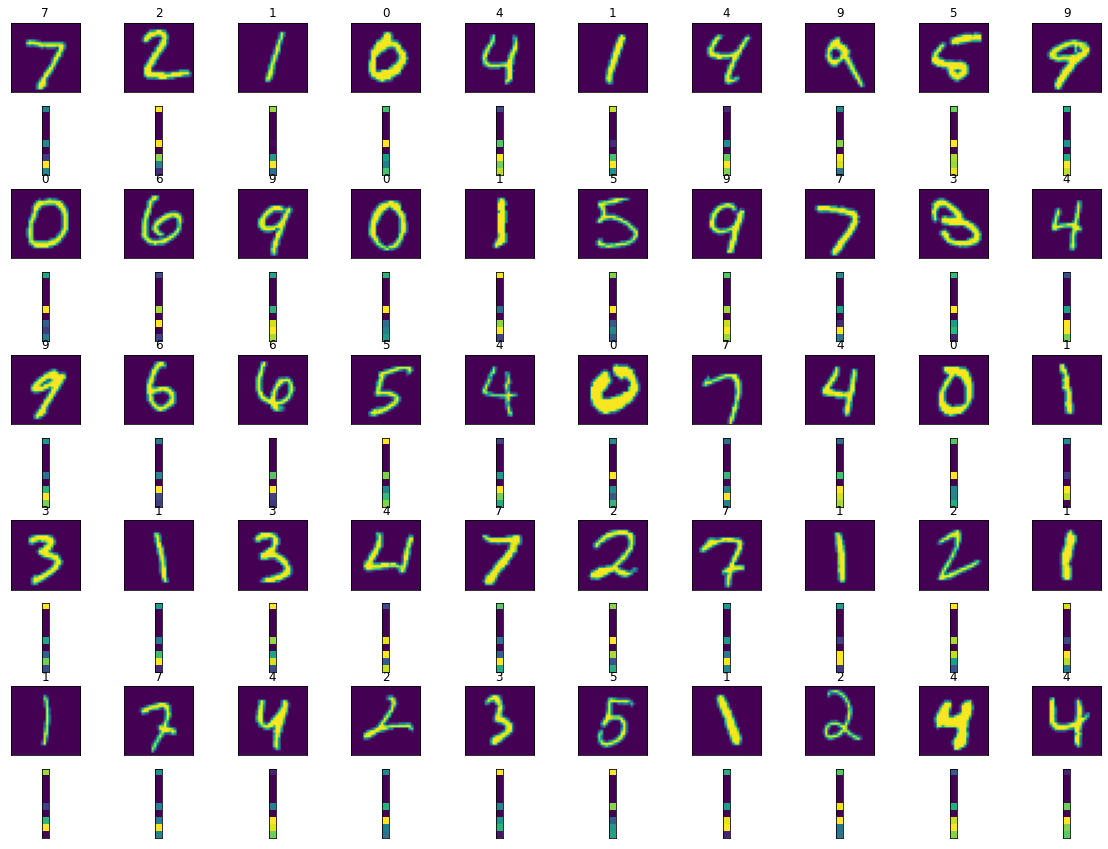

In [55]:
cols = 10
rows = 5
fig = plt.figure(figsize=(cols*2,rows*3))
for i in range(cols*rows):
    row = i // cols
    col = i % cols
    in_t, number = mnist_val[i]
    out_t = encoder_model(in_t.view(-1).unsqueeze(0))
    in_img = in_t.permute(1,2,0)
    out_img = out_t.view(1,10,1).permute(1,2,0).detach()

    ax = fig.add_subplot(2*rows, cols, 1+2*row*cols+ col, xticks=[], yticks=[])
    ax.set_title(f"{number}")
    plt.imshow(in_img)
    ax = fig.add_subplot(2*rows, cols, 1+2*row*cols+cols+ col, xticks=[], yticks=[])
    plt.imshow(out_img)
plt.show()

It's probably not appropriate to have a 10-D latent space in this case, since the autoencoder has to recreate more details than just what digit it is (like the idiosyncrasies of each handwriting). But it still works somewhat well, so that's cool, I guess...